In [1]:
import sys
import math
from tabnanny import check
sys.path.append('../data')

from pantry_database import misc 
from scipy.special import softmax
from scipy import spatial
import numpy as np
from gensim.models import Word2Vec
import gensim.downloader

In [2]:

def catigory_score(pantryGroup, groceryGroup):
    Pvector = np.array([x for x in pantryGroup.values()])
    Gvector = np.array([x for x in groceryGroup.values()])
    if sum(Pvector) == 0 or sum(Gvector) == 0:
        score = 0
    else:
        score = 1- spatial.distance.cosine(Pvector, Gvector) 
        # Try score with difference similarity functions 
        #spatial.distance.eclidean(Pvector, Gvector) 
        #spatial.distance.jaccard(Pvector, Gvector) 
    return score

def word2vec_score(glove_wiki_vec,pantry,grocery):
    complex_words = [ "gummy-vitamins", "baby-formula", "condensed-milk", "alfredo-sauce","olive-oil", "granola-bars","pancake-mix", "peanut-butter", "grape-jam","bread-crumbs", "hot-sauce", "tomato-soup", "muffin-mix"]
    wd_score = 0 
    pantry = pantry.split("_")[0]
    grocery = grocery.split("_")[0]
    if pantry not in complex_words and grocery not in complex_words:
        wd_score += glove_wiki_vec.similarity(pantry, grocery)
    else:
        if pantry in complex_words and grocery in complex_words:
            pantry = pantry.split("-")
            grocery = grocery.split("-")
            pantry = glove_wiki_vec[pantry[0]] +  glove_wiki_vec[pantry[1]]
            grocery = glove_wiki_vec[grocery[0]] +  glove_wiki_vec[grocery[1]]
            pantry = np.array(pantry)
            grocery = np.array(grocery)
            wd_score = pantry.dot(grocery)/np.linalg.norm(grocery)/np.linalg.norm(pantry)
        elif pantry in complex_words:
            pantry = pantry.split("-")
            pantry = glove_wiki_vec[pantry[0]] +  glove_wiki_vec[pantry[1]]
            grocery = glove_wiki_vec[grocery]
            pantry = np.array(pantry)
            grocery = np.array(grocery)
            wd_score = pantry.dot(grocery)/np.linalg.norm(grocery)/np.linalg.norm(pantry)
        elif grocery in complex_words:
            grocery = grocery.split("-")
            grocery = glove_wiki_vec[grocery[0]] +  glove_wiki_vec[grocery[1]]
            pantry = glove_wiki_vec[pantry]
            pantry = np.array(pantry)
            grocery = np.array(grocery)
            wd_score = pantry.dot(grocery)/np.linalg.norm(grocery)/np.linalg.norm(pantry)
    
    return wd_score

In [3]:
glove_wiki_vec = gensim.downloader.load('glove-wiki-gigaword-300')
#glove_wiki_vec = gensim.downloader.load('glove-twitter-100')
print("done")

done


In [13]:
# FOOD_GROUP_WEIGHT =  0.7749049648288351
# CONTAINER_WEIGHT = 0.7148143272203293
# STABLE_WEIGHT = 0.727312776359687
# PURPOSE_WEIGHT = 0.985281033562436
# WORD2VECT_WEIGHT = 0.8022233915876426




FOOD_GROUP_WEIGHT = .5
CONTAINER_WEIGHT = 1
STABLE_WEIGHT = 1
PURPOSE_WEIGHT = 1
WORD2VECT_WEIGHT = .5



def cluster(pantry_items, grocery_items):
    """
    Return: 
        { grocy_item: [(pantry_item, score), (pantry_item,score)], grocery....}
    """
    #glove_wiki_vec = gensim.downloader.load('glove-wiki-gigaword-300')
    clusters = {}
    for grocery in grocery_items:
        score_list = []
        for pantry_obj in pantry_items:

            fg_score = FOOD_GROUP_WEIGHT *  catigory_score(misc[pantry_obj]["Food_Groups"], misc[grocery]["Food_Groups"])
            print("FG:",fg_score)
            continer_score = CONTAINER_WEIGHT *  catigory_score(misc[pantry_obj]["Continer"], misc[grocery]["Continer"])
            print("CG:",continer_score)
            
            stability_score = STABLE_WEIGHT * catigory_score(misc[pantry_obj]["Stability"], misc[grocery]["Stability"])
            print("S:",stability_score)
            purpose_score = PURPOSE_WEIGHT * catigory_score(misc[pantry_obj]["Purpose"], misc[grocery]["Purpose"])
#             sum(np.array([x for x in misc[pantry_obj]["Purpose"].values()]) *
#                          np.array([x for x in misc[grocery]["Purpose"].values()]))
            print("P:",purpose_score)
            wdVec_score = WORD2VECT_WEIGHT * word2vec_score(glove_wiki_vec ,pantry_obj,grocery)
            print("W2:",wdVec_score)
            
            score = fg_score + continer_score + stability_score + purpose_score + wdVec_score
            score_list.append(( pantry_obj, score))
            # if pantry_obj in self.shelf1:
            #     score_list.append(( pantry_obj, score, self.shelf1))
            # elif pantry_obj in self.shelf2:
            #     score_list.append(( pantry_obj, score, self.shelf2))
                
        
        score_list.sort( key = lambda x: x[1], reverse=True)
        clusters[grocery] = score_list

    #self.clustered = clusters      
    return clusters

In [19]:
pantry = [ "ketchup_b"]
#pantry = [ "hot-sauce","cookies", "ketchup_b", "muffin-mix", "granola-bars",  "pringles"]
grocerys = [ "hot-sauce"]
#grocerys= ["tomato-soup", "hot-sauce", "pancake-mix", "peanut-butter"]
cluster_list = cluster(pantry, grocerys)
#print(cluster_list)

FG: 0.5
CG: 1.0
S: 1.0
P: 0
W2: 0.25698456168174744


In [55]:
from sklearn.preprocessing import StandardScaler
def cluster_covariance_matrix():
    variables_len = 5
    num_objs = len(misc)
    print(num_objs)
    misc_keys = [x for x in misc.keys()]
    # 946 is the combination of our 43 object with no repeats 
    X = np.zeros((1326, variables_len))
    i = 0
    checked_set = set()
    cnt = 0     
    for _ in range(i, num_objs):
        j = 0
        for _ in range(j,num_objs):
            fg, cg, s, p = 0,0,0,0
            wd_score = 0 
            current_obj = misc_keys[i]
            obj = misc_keys[j]
            if (current_obj, obj) not in checked_set and (obj, current_obj) not in checked_set:
                checked_set.add((current_obj, obj))
                fg = catigory_score(misc[current_obj]["Food_Groups"], misc[obj]["Food_Groups"])
                cg = catigory_score(misc[current_obj]["Continer"], misc[obj]["Continer"])
                #s = sum(np.array([x for x in misc[current_obj]["Stability"].values()]) *
                #         np.array([x for x in misc[obj]["Stability"].values()]))
#                 p = sum(np.array([x for x in misc[current_obj]["Purpose"].values()]) *
#                          np.array([x for x in misc[obj]["Purpose"].values()]))
                s = catigory_score(misc[current_obj]["Stability"], misc[obj]["Stability"])
                p = catigory_score(misc[current_obj]["Purpose"], misc[obj]["Purpose"])
                # wd2Vec score 
                wd_score = word2vec_score(glove_wiki_vec, current_obj, obj)
        
                X[cnt][0] = fg 
                X[cnt][1] = cg 
                X[cnt][2] = s 
                X[cnt][3] = p 
                X[cnt][4] = wd_score
                cnt += 1
            j +=1
        i +=1
    print(cnt)
           

    print("printing X")
    #print(X)
    #X = normalize(X,axis=0,norm='max')
    Xs = StandardScaler().fit_transform(X)
    #print(X)
    #X_bar = np.mean(X,axis=0)
    
    #print("pringint X_bar")
    #print(X_bar)
    
    #B = X - X_bar
    #print("printing B")
    #print(B)
    #print("Printing BT*B")
    #B_p = B.T.dot(B) / 946
    #print(B_p)
    Cv =np.corrcoef(Xs.T)
    print("pringint Cv")
    print(Cv)
    C = np.cov(Xs, rowvar=False)
    print("Printing C")
    print(C)
    
    values, vector = np.linalg.eig(C)
    print("Values")
    print(values)
    print("Vectors")
    print(vector)
    
#     print("Pincipal")
#     T = B.dot(vector)
#     #T = vector.T.dot(B.T)
#     print(T)
    return X, C, vector, values


X, C, Vect, EV = cluster_covariance_matrix()

51
1326
printing X
pringint Cv
[[1.         0.43103944 0.22834995 0.32083933 0.4606701 ]
 [0.43103944 1.         0.29319397 0.15244776 0.25318034]
 [0.22834995 0.29319397 1.         0.12872188 0.1598599 ]
 [0.32083933 0.15244776 0.12872188 1.         0.28192565]
 [0.4606701  0.25318034 0.1598599  0.28192565 1.        ]]
Printing C
[[1.00075472 0.43136475 0.22852229 0.32108147 0.46101777]
 [0.43136475 1.00075472 0.29341525 0.15256281 0.25337142]
 [0.22852229 0.29341525 1.00075472 0.12881903 0.15998055]
 [0.32108147 0.15256281 0.12881903 1.00075472 0.28213842]
 [0.46101777 0.25337142 0.15998055 0.28213842 1.00075472]]
Values
[2.12256476 0.47455592 0.96262041 0.77849775 0.66553474]
Vectors
[[-0.54998368 -0.78189679  0.10312379  0.26765347 -0.06230941]
 [-0.45986999  0.43378826 -0.40722333  0.34898242 -0.55922068]
 [-0.34340436 -0.06469748 -0.65995385 -0.55507166  0.3663933 ]
 [-0.3786229   0.14219539  0.52639864 -0.65109218 -0.36797911]
 [-0.47408405  0.41959488  0.33301657  0.27303355  0

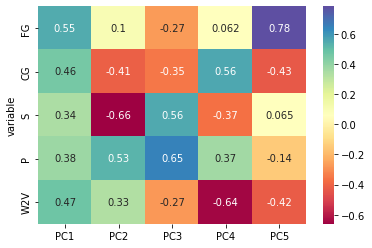

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
loadings = pca.components_
num_pc = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
#loadings_df = pd.DataFrame.from_dict(dict(zip(["FG","CG","S","P","W2V"],C)))
loadings_df['variable'] = labels=["FG","CG","S","P","W2V"]
# loadings_df['variable'] = X_scaled.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()
from bioinfokit.visuz import cluster
#cluster.screeplot(obj=[pc_list, pca.explained_variance_ratio_])

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

#print(X)
# Standardizing the features
X_scaled = StandardScaler().fit_transform(X)
#print(X_scaled)

#X_normal = normalize(X,axis=0,norm='max')
# print(X_normal)

pca = PCA(n_components=5)
#pca1 = PCA(n_components=5)
PCA_X = pca.fit_transform(X_scaled)
#principalComponents1 = pca1.fit_transform(X_normal)

print(pca.explained_variance_)
print(pca.components_)
print(pca.n_features_)
print(pca.explained_variance_ratio_)
#print(pca1.explained_variance_)
#print(pca1.components_)
#print(principalComponents)


[2.12256476 0.96262041 0.77849775 0.66553474 0.47455592]
[[ 0.54998368  0.45986999  0.34340436  0.3786229   0.47408405]
 [ 0.10312379 -0.40722333 -0.65995385  0.52639864  0.33301657]
 [-0.26765347 -0.34898242  0.55507166  0.65109218 -0.27303355]
 [ 0.06230941  0.55922068 -0.3663933   0.36797911 -0.64322398]
 [ 0.78189679 -0.43378826  0.06469748 -0.14219539 -0.41959488]]
5
[0.42419281 0.19237889 0.15558213 0.13300657 0.09483961]


In [66]:
# get PCA loadings plots (2D and 3D)
# 2D
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=["FG","CG","SA","PU","W2V"], 
    var1=round(pca.explained_variance_ratio_[0]*100, 2),
    var2=round(pca.explained_variance_ratio_[1]*100, 2))

# 3D
cluster.pcaplot(x=loadings[0], y=loadings[1], z=loadings[2],  labels=["FG","CG","SA","PU","W2V"], 
    var1=round(pca.explained_variance_ratio_[0]*100, 2), var2=round(pca.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca.explained_variance_ratio_[2]*100, 2))

In [26]:
c1 = Vect[:,0]
c2 = Vect[:,1]
c3 = Vect[:,2]

c1_t, c2_t, c3_t = 0,0,0

for i in range(0,len(c1)):
    c1_t += np.exp(c1[i])
    c2_t += np.exp(c2[i])
    c3_t += np.exp(c3[i])


Wfg = EV[0]*np.exp(c1[0])/c1_t + EV[1]*np.exp(c2[0])/c2_t + EV[2]*np.exp(c3[0])/c3_t
Wcg = EV[0]*np.exp(c1[1])/c1_t + EV[1]*np.exp(c2[1])/c2_t + EV[2]*np.exp(c3[1])/c3_t
Ws = EV[0]*np.exp(c1[2])/c1_t + EV[1]*np.exp(c2[2])/c2_t + EV[2]*np.exp(c3[2])/c3_t
Wp = EV[0]*np.exp(c1[3])/c1_t + EV[1]*np.exp(c2[3])/c2_t + EV[2]*np.exp(c3[3])/c3_t
Ww2v = EV[0]*np.exp(c1[4])/c1_t + EV[1]*np.exp(c2[4])/c2_t + EV[2]*np.exp(c3[4])/c3_t
print(Wfg)
print(Wcg)
print(Ws)
print(Wp)
print(Ww2v)

0.727084095690635
0.7478275607167041
0.9189453904704765
0.6523514830145654
0.5840904303606396


In [1]:
###### From this cell lower is all testing of funcitonality. Not used for clustering or data collection

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

pca_data = pd.DataFrame(PCA_X,columns=['PC1','PC2']) 
kmeans =KMeans(n_clusters=5).fit(X_scaled)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)

NameError: name 'PCA_X' is not defined

In [74]:

from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)
# calculate the mean of each column
M = mean(A.T, axis=1)
#print(M)
# center columns by subtracting column means
C = A - M
#print(C)
# calculate covariance matrix of centered matrix
print("Cov")
V = cov(C.T)
print(V)
# eigendecomposition of covariance matrix
values, vectors = eig(V)
print("vectors")
print(vectors)
print("values")
print(values)
# project data
P = vectors.T.dot(C.T)
print("Principle")
print(P.T)

[[1 2]
 [3 4]
 [5 6]]
Cov
[[4. 4.]
 [4. 4.]]
vectors
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
values
[8. 0.]
Principle
[[-2.82842712  0.        ]
 [ 0.          0.        ]
 [ 2.82842712  0.        ]]


In [84]:
# Principal Component Analysis
from numpy import array
from sklearn.decomposition import PCA
# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)
# create the PCA instance
pca = PCA(2)
# fit on data
pca.fit(A)
# access values and vectors
print("componets")
print(pca.components_)
print("variance")
print(pca.explained_variance_)
# transform data
B = pca.transform(A)
print("Transfrom")
print(B)

[[1 2]
 [3 4]
 [5 6]]
componets
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
variance
[8. 0.]
Transfrom
[[-2.82842712e+00 -2.22044605e-16]
 [ 0.00000000e+00  0.00000000e+00]
 [ 2.82842712e+00  2.22044605e-16]]
